# Artificial Chris

The goal is to create a chatbot, given a variable length input sequence to output a variable length output that sounds like Chris is writing it.

In [1]:
import numpy as np
import pandas as pd

import os
import re
import glob

!pip install emoji
import emoji

# keras with tensorflow backend
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.layers import Flatten, RepeatVector, TimeDistributed, CuDNNLSTM
from keras.optimizers import RMSprop
from keras.utils import to_categorical, np_utils
from keras.callbacks import EarlyStopping

from keras.models import Sequential

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
% matplotlib inline
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 100

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


## Load Data from Txt

In [2]:
data_folder = "data"
txt_files = glob.glob(os.path.join(data_folder, '*.txt'))

In [ ]:
def clean_name(name):
    corr = re.sub('[^A-Za-z0-9öüäéè ]+', '', name)
    if (corr[-1] == ' '):
        corr = corr[:-1]
    return corr

In [ ]:
def get_df_from_txt_file(file_name):
    f = open(file_name)
    file_name = os.path.split(file_name)[1]
    
    date = []
    time = []
    sender = []
    reciever = []
    message = []

    partner_name = file_name[18:-4] + ": "
    chris_name = 'Christoph Bernkopf: '

    for line in f:
        if(len(line) < 2 or "Nachrichten in diesem Chat sowie Anrufe" in line):
    #         print("skip line")
            continue
        if(line[15:18] == " - " and line[2] == "." and line[5] == "."):
            date.append(line[:8])
            time.append(line[10:15])
            if (chris_name in line[18:]):
                sender.append(clean_name(chris_name[:-2]))
                reciever.append(clean_name(partner_name[:-2]))
            else:
                reciever.append(clean_name(chris_name[:-2]))
                sender.append(clean_name(partner_name[:-2]))
            message.append(line[18:].replace(partner_name, '').replace(chris_name, ''))

    df = pd.DataFrame(date, columns=['date'])
    df['time'] = time
    df['sender'] = sender
    df['reciever'] = reciever
    df['message'] = message

    return df

In [ ]:
try:
    del df
except:
    None

for file_name in txt_files:
    print(file_name)
    curr_df = get_df_from_txt_file(file_name)
    if ('df' in locals()):
        df = pd.concat([df, curr_df])
    else:
        df = curr_df
    df = df.reset_index(drop=True)
    print(curr_df.shape, df.shape)

## Aggregate Messages into Inputs and Targets

In [ ]:
remove_list = ['<Medien ausgeschlossen>', '\n', 'Martin TPH CERN <3: ', 'Christoph Gerhardus :): ', 'Megan :): ', 'Standort: ']

for item in remove_list:
    df['message'] = df['message'].apply(lambda x: x.replace(item, ''))

# df['message'] = df['message'][df['message'].astype('str').str[:10] != "Standort: "]

# get rid of links
df['message'] = df['message'].apply(lambda x: re.sub(r'http\S+', '', x))

# get rid of nan messages
df['message'] = df['message'].apply(lambda x : x if type(x) == str else "")

df = df[df['message'] != ""]

In [ ]:
def func(x):
    if (type(x) != str):
        print(x)
        
df['message'].apply(lambda x: func(x));

In [ ]:
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI

def char_is_spe_char(character):
    return character in "?!."

def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

def text_has_spe_char(text):
    for character in text:
        if character in "?!.":
            return True
    return False

In [ ]:
def space_emoijis(x):
    if (text_has_emoji(x) or text_has_spe_char(x)):
        result = ''
        if (len(x) == 1):
            return result
        for ch in x:
            if (char_is_emoji(ch)):
                result = result + ' ' + ch
            elif (char_is_spe_char(ch)):
                result = result + ' ' + ch
            else:
                result = result + ch
        return result
    else:
        return x

In [ ]:
df['message'] = df['message'].apply(lambda x: space_emoijis(x))

In [ ]:
df['sender'].unique()

In [ ]:
def get_message(i,j):
    msg = df.iloc[i:j,df.columns.get_loc('message')].values
    assert msg.shape[0] > 0

    if (msg.shape[0] > 1):
        inpu = msg[0]
        for m in msg[1:]:
            inpu = "%s \n %s" % (inpu, m)
    else:
        inpu = msg[0]
        
    return inpu

In [ ]:
def get_agg_message(i, name):
    col = df.columns.get_loc('reciever')
    
    for j in range(1000):
        j = i + j
        if (name == df.iloc[j,col]):
            break    
    inpu = get_message(i,j)
        
    for k in range(1000):
        k = j + k
        if (name != df.iloc[k,col]):
            break
    target = get_message(j,k)
    
    return inpu, target, k-1

In [ ]:
inp = []
tar = []
sen = []
rec = []

i = 0
while i<(len(df)-10):
# while i<15:
    # get input & target
    col = df.columns.get_loc('sender')
    name = df.iloc[i,col]
    next_names = df.iloc[i+1:i+10,col].values
    if (name != "Christoph Bernkopf" and name in next_names):
        inpu, target, i = get_agg_message(i, name)    
        inp.append(inpu)
        tar.append(target)
        sen.append(name)
        rec.append("Christoph Bernkopf")
    i += 1

In [ ]:
dfn = pd.DataFrame(inp, columns=['input'])
dfn['target'] = tar
dfn['sender'] = sen
dfn['reciever'] = rec

## A little bit of filtering

In [ ]:
dfn = dfn[dfn['input'].astype('str').str.len()>20]

In [ ]:
dfn.head()

In [ ]:
dfn.to_pickle(os.path.join(data_folder, "preprocessed_data.pkl"))

# EDA

In [132]:
dfn = pd.read_pickle(os.path.join(data_folder, "preprocessed_data.pkl"))

In [133]:
X = dfn['input'].values
y = dfn['target'].values

In [134]:
max_words = 20000
tok = Tokenizer(num_words=max_words, filters='"#$%&()*+,-./;<=>@[\]^_`{|}~ ')
tok.fit_on_texts(np.concatenate([X,y]))

def tok_and_pad(arr):
    sequences = tok.texts_to_sequences(arr)
    return sequences

X = tok_and_pad(X)
y = tok_and_pad(y)

In [135]:
lengths = np.array([len(elem) for elem in X])
y_lengths = np.array([len(elem) for elem in y])
lengths[lengths>50].shape, y_lengths[y_lengths>50].shape

((419,), (132,))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


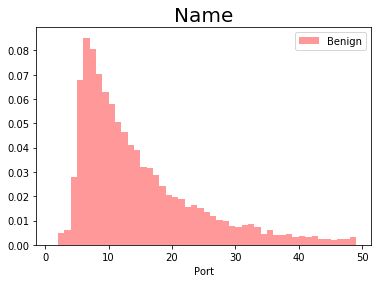

In [124]:
val = 25
sns.distplot(lengths[lengths<50],kde=False,
             axlabel="Port",label="Benign",color="R", norm_hist=True);
plt.legend();
plt.title("Name",fontsize=20);
# plt.savefig(os.path.join("EDA_plots", col, name))
plt.show()
# plt.clf()

# Test: classify input by sender

In [3]:
dfn = pd.read_pickle(os.path.join(data_folder, "preprocessed_data.pkl"))

In [ ]:
X = dfn['input'].values
y = dfn['sender'].values
le = LabelEncoder()
y = le.fit_transform(y)
# y = y.reshape(-1,1)
le.classes_

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1)

In [ ]:
X_train[:5]

In [ ]:
max_words = 20000
max_len = 200
tok = Tokenizer(num_words=max_words, filters='"#$%&()*+,-./;<=>@[\]^_`{|}~ ')
tok.fit_on_texts(X_train)

def tok_and_pad(arr):
    sequences = tok.texts_to_sequences(arr)
    return sequence.pad_sequences(sequences,maxlen=max_len)

train_sequences_matrix = tok_and_pad(X_train)
val_sequences_matrix = tok_and_pad(X_val)
test_sequences_matrix = tok_and_pad(X_test)

In [ ]:
# tok.word_counts
names = ['word','count']
formats = ['object','f8']
dtype = dict(names = names, formats=formats)
arr = np.array(list(tok.word_counts.items()), dtype=dtype)
arr = pd.DataFrame(arr)
arr.sort_values(by=['count'], ascending=False).head()

## Baselines

In [ ]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(train_sequences_matrix, y_train)
acc_dummy_classifier = dummy_classifier.score(val_sequences_matrix, y_val)
acc_dummy_classifier

In [ ]:
u, indices = np.unique(y_val, return_inverse=True)
most_freq_y_val = u[np.argmax(np.bincount(indices))]
le.inverse_transform(most_freq_y_val)

In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(train_sequences_matrix, y_train)
tree_score = tree.score(val_sequences_matrix, y_val)
tree_score

## Classification RNN

https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [ ]:
class Attention(keras.layers.Layer):

    def __init__(self, key_dim=None, **kwargs):
        self.key_dim = key_dim
        super(Attention, self).__init__(**kwargs)

        
    def build(self, input_shape):
         # Weights initializer function
        w_initializer = keras.initializers.glorot_uniform()

        # Biases initializer function
        b_initializer = keras.initializers.Zeros()
        
        #Matrix to extract the keys
        self.key_extract = self.add_weight(name='feature_extract', 
                                      shape=(int(input_shape[2]),int(self.key_dim)),
                                      initializer=w_initializer,
                                      trainable=True)
        #Key Bias
        self.key_bias = self.add_weight(name='feaure_bias', 
                                      shape=(int(1),int(self.key_dim)),
                                      initializer=b_initializer,
                                      trainable=True)
        
        #The Query representing the class
        self.Query = self.add_weight(name='Query', 
                                      shape=(int(self.key_dim),int(1)),
                                      initializer=w_initializer,
                                      trainable=True)

        super(Attention, self).build(input_shape) 


    def call(self, x):
        #Extract the Keys
        keys=tf.tensordot(x,self.key_extract,axes=[2,0])+self.key_bias
        
        #Calculate the similarity between keys and the Query
        similar_logits=tf.tensordot(keys,self.Query,axes=[2,0])
        
        #Normalize it to be between 0 and 1 and sum to 1
        attention_weights = tf.nn.sigmoid(similar_logits)
        
        #Use these Weights to aggregate
        weighted_input = tf.matmul(x, attention_weights, transpose_a=True)

        return [weighted_input, attention_weights]


    def compute_output_shape(self, input_shape):
        return [(input_shape[0],input_shape[2],int(1)), (input_shape[0],input_shape[1],1)]
    
    
    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config['key_dim'] = self.key_dim
        return base_config

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = CuDNNLSTM(64, return_sequences=True)(layer)
    layer, attention_weights = Attention(256)(layer)
    layer = Flatten()(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(len(le.classes_),name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.fit(train_sequences_matrix,
          y_train,
          batch_size=128,
          epochs=10,
          validation_data=(val_sequences_matrix, y_val),
          callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
         )

In [ ]:
accr = model.evaluate(test_sequences_matrix,y_test)

In [ ]:
print("test accuracy %f" % accr[1])
# not bad

# Obtain an output sequence

In [225]:
dfn = pd.read_pickle(os.path.join(data_folder, "preprocessed_data.pkl"))

In [226]:
X = dfn['input'].values
y = dfn['target'].values

In [227]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.1)

In [228]:
X.shape, np.concatenate([X,y]).shape

((10904,), (21808,))

- Tokeization starts at 1 (0 is not a token key)
- Start == -1
- End == -2

In [229]:
max_words = 20000
max_len = 50
tok = Tokenizer(num_words=max_words, filters='"#$%&()*+,-./;<=>@[\]^_`{|}~ ')
tok.fit_on_texts(np.concatenate([X,y]))

def tok_and_pad(arr, flag):
    if (flag == "input"):
        sequences = tok.texts_to_sequences(arr)
        return sequence.pad_sequences(sequences,maxlen=max_len)
    else:
        sequences = tok.texts_to_sequences(arr)
        for i in range(len(sequences)):
            sequences[i] = np.insert(sequences[i][:48], 0, -1, axis=0)
            sequences[i] = np.append(sequences[i], [-2])
        return sequence.pad_sequences(sequences,maxlen=max_len)

X_train = tok_and_pad(X_train, "input")
X_test = tok_and_pad(X_test, "input")
X_val = tok_and_pad(X_val, "input")
y_train = tok_and_pad(y_train, "target")
y_test = tok_and_pad(y_test, "target")
y_val = tok_and_pad(y_val, "target")

# reverse_word_map = dict(map(reversed, tok.word_index.items()))

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [230]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, inputs, targets, batch_size=32, n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.inputs = inputs
        self.targets = targets
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = self.inputs[list_IDs_temp]
        y = np_utils.to_categorical(self.targets[list_IDs_temp], num_classes=max_words)

        return X, y

In [231]:
# Parameters
params = {'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
train_keys = np.arange(y_train.shape[0])
val_keys = np.arange(y_val.shape[0])
test_keys = np.arange(y_test.shape[0])

# Generators
training_generator = DataGenerator(train_keys, X_train, y_train, **params)
validation_generator = DataGenerator(val_keys, X_val, y_val, **params)
test_generator = DataGenerator(test_keys, X_test, y_test, **params)

## One-Shot Model

https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/

In [253]:
vocab_size = max_words
src_txt_length = max_len
sum_txt_length = max_len

def RNN():
    # encoder input model
    inputs = Input(shape=(src_txt_length,))
    encoder1 = Embedding(vocab_size, 128)(inputs)
    encoder2 = CuDNNLSTM(128)(encoder1)
    encoder3 = RepeatVector(sum_txt_length)(encoder2)
    
    # decoder output model
    decoder1 = LSTM(128, return_sequences=True)(encoder3)
    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder1)

    # tie it together
    model = Model(inputs=inputs, outputs=outputs)
    
    print("inputs.shape  ", inputs.shape)
    print("encoder1.shape", encoder1.shape)
    print("encoder2.shape", encoder2.shape)
    print("encoder2.shape", encoder2.shape)
    print("decoder1.shape", decoder1.shape)
    print("outputs.shape ", outputs.shape)

    return model

In [254]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # RMSprop(),
              metrics=['accuracy'])

inputs.shape   (?, 50)
encoder1.shape (?, 50, 128)
encoder2.shape (?, 128)
encoder2.shape (?, 128)
decoder1.shape (?, ?, 128)
outputs.shape  (?, 50, 20000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 50, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 128)           131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 20000)      

In [234]:
model.fit_generator(generator=training_generator,
          validation_data=validation_generator,
          epochs=1,
         )

Epoch 1/1
137/137 [==============================] - 61s 449ms/step - loss: 3.3747 - acc: 0.7448 - val_loss: 2.1133 - val_acc: 0.7453


In [235]:
pred = model.predict_generator(test_generator)

pred[batch, word_idx, onehot_idx]

In [247]:
pred[0:5,0,0:5]

array([[0.31431735, 0.02391104, 0.00807253, 0.00719736, 0.00413261],
       [0.3143364 , 0.02391174, 0.00807264, 0.00719746, 0.00413263],
       [0.31431907, 0.02391112, 0.00807255, 0.00719737, 0.00413261],
       [0.3143433 , 0.023912  , 0.00807267, 0.0071975 , 0.00413264],
       [0.31433165, 0.02391155, 0.0080726 , 0.00719743, 0.00413262]],
      dtype=float32)

In [246]:
pred[0:5,45,0:5]

array([[0.7618257 , 0.02581327, 0.00619482, 0.00533127, 0.00257122],
       [0.7618257 , 0.02581327, 0.00619482, 0.00533127, 0.00257122],
       [0.7618257 , 0.02581327, 0.00619482, 0.00533127, 0.00257122],
       [0.7618257 , 0.02581327, 0.00619482, 0.00533127, 0.00257122],
       [0.7618257 , 0.02581327, 0.00619482, 0.00533127, 0.00257122]],
      dtype=float32)

Get token key with np.argmax

In [252]:
pred[0][10]

array([7.6182568e-01, 2.5813272e-02, 6.1948155e-03, ..., 2.0243035e-06,
       1.9762900e-02, 1.9717563e-02], dtype=float32)

In [251]:
np.argmax(pred[0][10], axis=0)

0

In [249]:
y_train[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   -1,  295,   45,    1,
         16, 2038,  391, 1817,    8,   -2], dtype=int32)

In [250]:
np.argmax(y_train[10], axis=0)

45

## Keras Seq2Seq

In [13]:
# HIDDEN_UNITS = 50

# encoder_inputs = Input(shape=(max_len,), name='encoder_inputs')
# encoder_embedding = Embedding(input_dim=max_words, output_dim=HIDDEN_UNITS,
#                               input_length=max_len, name='encoder_embedding')
# encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
# encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
# encoder_states = [encoder_state_h, encoder_state_c]

# decoder_inputs = Input(shape=(None, max_words), name='decoder_inputs')
# decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
# decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
#                                                                  initial_state=encoder_states)
# decoder_dense = Dense(units=max_words, activation='softmax', name='decoder_dense')
# decoder_outputs = decoder_dense(decoder_outputs)

# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# model.summary()